In [1]:
# import rpy2.robjects.packages as rpackages
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1) 
# #packnames = ('ggplot2', 'lme4', 'reshape2', 'tidyverse')
# packnames = ('ggrepel')
# from rpy2.robjects.vectors import StrVector
# #utils.install_packages(StrVector(packnames))
# utils.install_packages(packnames)

In [24]:
import numpy as np
import pandas as pd
import re
import pickle
pd.options.mode.chained_assignment = None
from scipy.special import expit
from collections import Counter, defaultdict

from scipy.stats import spearmanr, norm

import matplotlib.pyplot as plt
import seaborn as sns
import rpy2

%matplotlib inline
%load_ext rpy2.ipython

_ = %R library(tidyverse)
_ = %R library(ggrepel)
_ = %R library(reshape2)
_ = %R library(brms)
_ = %R library(lme4)
_ = %R palette <- c("#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00")
_ = %R palette2 <- c("#525E62", "#C93312", "#FAEFD1", "#DC863B")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
data_path = "../data/"

In [4]:
data = pd.read_csv(data_path + "bulk_data_temporal_duration.csv")

## Split into dev:
train = data[data.split=="train"]
dev = data[data.split=="dev"]
test = data[data.split=="test"]
print(train.shape)
print(dev.shape)
print(test.shape)

pilot5 = dev
pilot5.head()

(53910, 22)
(16305, 22)
(14910, 22)


,split,worker_id,hit_id,sentence_id_1,pred1_token,pred1_root_token,sentence_id_2,pred2_token,pred2_root_token,sent_token,...,pred2_text,pred2_lemma,pred1_slider,pred1_duration,pred2_slider,pred2_duration,pred1_dur_conf,pred2_dur_conf,relation_conf,sentence
53910,dev,84,10769,en-ud-dev.conllu 31,12,12,en-ud-dev.conllu 32,19,19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,...,promised,promise,0 - 6,2,7 - 10,2,4,4,4,Xinhua reports that a wide range of Iraqi poli...
53911,dev,84,10769,en-ud-dev.conllu 1215,1_2_3,3,en-ud-dev.conllu 1216,7,7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,...,did,do,0 - 15,7,13 - 16,1,1,4,2,It s a Reel and i have danced to it before .. ...
53913,dev,84,10769,en-ud-dev.conllu 217,11,11,en-ud-dev.conllu 217,19,19,en-ud-dev.conllu 217_11 en-ud-dev.conllu 217_19,...,issuing,issue,0 - 10,6,10 - 13,3,3,4,3,Someone in the CPA sat down and thought up way...
53915,dev,549,10769,en-ud-dev.conllu 31,12,12,en-ud-dev.conllu 32,19,19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,...,promised,promise,0 - 15,5,8 - 27,5,2,2,2,Xinhua reports that a wide range of Iraqi poli...
53916,dev,549,10769,en-ud-dev.conllu 1215,1_2_3,3,en-ud-dev.conllu 1216,7,7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,...,did,do,0 - 21,4,8 - 15,4,3,3,3,It s a Reel and i have danced to it before .. ...


In [5]:
pilot5.pred1_slider.dtype

dtype('O')

## Remove empty slider positions

In [6]:
print(pilot5.shape)
pilot5 = pilot5[(pilot5.pred1_slider!="{}") &
                   (pilot5.pred2_slider!="{}")]
print(pilot5.shape)

(16305, 22)
(16304, 22)


In [7]:
pilot5['pred1_slider1'] = pilot5.pred1_slider.map(lambda x: int(x.split(' - ')[0]))
pilot5['pred1_slider2'] = pilot5.pred1_slider.map(lambda x: int(x.split(' - ')[1]))
pilot5['pred2_slider1'] = pilot5.pred2_slider.map(lambda x: int(x.split(' - ')[0]))
pilot5['pred2_slider2'] = pilot5.pred2_slider.map(lambda x: int(x.split(' - ')[1]))

pilot5['sent1_token'] = pilot5['sentence_id_1'] + '_' + pilot5['pred1_token']
pilot5['sent2_token'] = pilot5['sentence_id_2'] + '_' + pilot5['pred2_token']

pilot5.head()

,split,worker_id,hit_id,sentence_id_1,pred1_token,pred1_root_token,sentence_id_2,pred2_token,pred2_root_token,sent_token,...,pred1_dur_conf,pred2_dur_conf,relation_conf,sentence,pred1_slider1,pred1_slider2,pred2_slider1,pred2_slider2,sent1_token,sent2_token
53910,dev,84,10769,en-ud-dev.conllu 31,12,12,en-ud-dev.conllu 32,19,19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,...,4,4,4,Xinhua reports that a wide range of Iraqi poli...,0,6,7,10,en-ud-dev.conllu 31_12,en-ud-dev.conllu 32_19
53911,dev,84,10769,en-ud-dev.conllu 1215,1_2_3,3,en-ud-dev.conllu 1216,7,7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,...,1,4,2,It s a Reel and i have danced to it before .. ...,0,15,13,16,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1216_7
53913,dev,84,10769,en-ud-dev.conllu 217,11,11,en-ud-dev.conllu 217,19,19,en-ud-dev.conllu 217_11 en-ud-dev.conllu 217_19,...,3,4,3,Someone in the CPA sat down and thought up way...,0,10,10,13,en-ud-dev.conllu 217_11,en-ud-dev.conllu 217_19
53915,dev,549,10769,en-ud-dev.conllu 31,12,12,en-ud-dev.conllu 32,19,19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,...,2,2,2,Xinhua reports that a wide range of Iraqi poli...,0,15,8,27,en-ud-dev.conllu 31_12,en-ud-dev.conllu 32_19
53916,dev,549,10769,en-ud-dev.conllu 1215,1_2_3,3,en-ud-dev.conllu 1216,7,7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,...,3,3,3,It s a Reel and i have danced to it before .. ...,0,21,8,15,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1216_7


In [8]:
def ridit_score(x):
    x = x.astype(int)
    x_max, x_min = x.max(), x.min()
    counts = x.value_counts()[list(range(x_max+1))].fillna(0)
    dist = counts/counts.sum()
    cumdist = dist.cumsum()
    
    def _ridit_score(i):
        if i != x_min: 
            return cumdist[i-1] + dist[i]/2
        else:
            return dist[i]/2
        
    return x.apply(_ridit_score)

pilot5['relation_conf_ridit'] = pilot5.groupby('worker_id').relation_conf.transform(ridit_score)
pilot5['pred1_dur_conf_ridit'] = pilot5.groupby('worker_id').pred1_dur_conf.transform(ridit_score)
pilot5['pred2_dur_conf_ridit'] = pilot5.groupby('worker_id').pred2_dur_conf.transform(ridit_score)

/Users/sidvash/anaconda/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [9]:
pilot5.shape

(16304, 31)

## Melted Sliders

In [10]:
pilot5_slider_melted = pd.melt(pilot5, 
                               id_vars=['worker_id', 'sent1_token', 'sent2_token',
                                        'sent_token', 'hit_id', 'relation_conf_ridit'], 
                               value_vars=['pred1_slider1', 'pred1_slider2', 'pred2_slider1', 'pred2_slider2'])

## Normalizinf Slider values to make it between 0 and 1
minvals = pilot5_slider_melted.groupby(['worker_id', 'sent_token']).value.transform(lambda x: x.min())

pilot5_slider_melted.loc[pilot5_slider_melted.value!=100, 'value'] = pilot5_slider_melted[pilot5_slider_melted.value!=100].value - minvals[pilot5_slider_melted.value!=100] 

maxvals = pilot5_slider_melted.groupby(['worker_id', 'sent_token']).value.transform(lambda x: x.max())

pilot5_slider_melted.value = pilot5_slider_melted.value.values/maxvals.values 

pilot5_slider_melted.head()

/Users/sidvash/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


,worker_id,sent1_token,sent2_token,sent_token,hit_id,relation_conf_ridit,variable,value
0,84,en-ud-dev.conllu 31_12,en-ud-dev.conllu 32_19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,10769,0.788732,pred1_slider1,0.0
1,84,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1216_7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,10769,0.267606,pred1_slider1,0.0
2,84,en-ud-dev.conllu 217_11,en-ud-dev.conllu 217_19,en-ud-dev.conllu 217_11 en-ud-dev.conllu 217_19,10769,0.471831,pred1_slider1,0.0
3,549,en-ud-dev.conllu 31_12,en-ud-dev.conllu 32_19,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,10769,0.211864,pred1_slider1,0.0
4,549,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1216_7,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,10769,0.627119,pred1_slider1,0.0


#### Fill NaN values with zero 

In [11]:
pilot5_slider_melted.fillna(0, inplace=True)
print(pilot5_slider_melted[pilot5_slider_melted.value.isnull()].shape)

(0, 8)


In [12]:
pilot5_slider_melted.shape

(65216, 8)

In [13]:
sum(pilot5_slider_melted.hit_id.isnull())

0

(array([ 20408.,   1525.,   1635.,   1367.,   1437.,   1677.,   1649.,
          1324.,   1687.,   1405.,   1891.,   1591.,   1196.,   1487.,
          1042.,   1200.,   1266.,    997.,   1188.,  19244.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

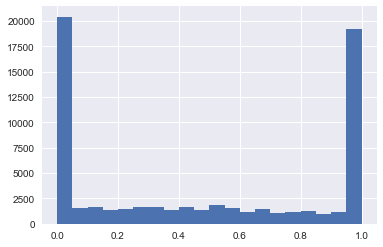

In [14]:
plt.hist(pilot5_slider_melted.value, bins=20)

## Melted Durations

In [15]:
pilot5_duration_melted = pd.melt(pilot5, 
                               id_vars=['worker_id', 'sent1_token', 'sent2_token', 
                                        'sent_token', 'hit_id', 'pred1_dur_conf_ridit', 'pred2_dur_conf_ridit'], 
                               value_vars=['pred1_duration', 'pred2_duration']).rename(columns={'variable': 'predpos', 'value': 'duration'}) 
print(pilot5_duration_melted.shape)
pilot5_duration_melted = pd.melt(pilot5_duration_melted, 
                                 id_vars=['worker_id', 'predpos', 'duration', 
                                        'sent_token', 'hit_id', 'pred1_dur_conf_ridit', 'pred2_dur_conf_ridit'], 
                                 value_vars=['sent1_token', 'sent2_token']).rename(columns={'variable': 'sentpos', 'value': 'sent'}) 
print(pilot5_duration_melted.shape)
pilot5_duration_melted = pilot5_duration_melted[pilot5_duration_melted[['predpos', 'sentpos']].apply(lambda x: x[0].split('_')[0][-1] in x[1], axis=1)]

pilot5_duration_melted = pd.melt(pilot5_duration_melted, 
                                 id_vars=['worker_id', 'predpos', 'duration', 'sent', 'sent_token', 'hit_id'], 
                                 value_vars=['pred1_dur_conf_ridit', 'pred2_dur_conf_ridit']).rename(columns={'variable': 'predposconf', 'value': 'conf'}) 
print(pilot5_duration_melted.shape)
pilot5_duration_melted = pilot5_duration_melted[pilot5_duration_melted[['predpos', 'predposconf']].apply(lambda x: x[0].split('_')[0][-1] in x[1], axis=1)]
print(pilot5_duration_melted.shape)
#conf_head = pilot5_duration_melted.variable.map(lambda x: x.split('_')[0] + '_dur_conf_ridit').values
pilot5_duration_melted.head()

(32608, 9)
(65216, 9)
(65216, 8)
(32608, 8)


,worker_id,predpos,duration,sent,sent_token,hit_id,predposconf,conf
0,84,pred1_duration,2,en-ud-dev.conllu 31_12,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,10769,pred1_dur_conf_ridit,0.760563
1,84,pred1_duration,7,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,10769,pred1_dur_conf_ridit,0.147887
2,84,pred1_duration,6,en-ud-dev.conllu 217_11,en-ud-dev.conllu 217_11 en-ud-dev.conllu 217_19,10769,pred1_dur_conf_ridit,0.450704
3,549,pred1_duration,5,en-ud-dev.conllu 31_12,en-ud-dev.conllu 31_12 en-ud-dev.conllu 32_19,10769,pred1_dur_conf_ridit,0.222034
4,549,pred1_duration,4,en-ud-dev.conllu 1215_1_2_3,en-ud-dev.conllu 1215_3 en-ud-dev.conllu 1216_7,10769,pred1_dur_conf_ridit,0.661017


In [16]:
sum(pilot5_duration_melted.hit_id.isnull())

0

## Creating Rank-difference Dataframes

In [17]:
from scipy.special import logit

pairs = pd.merge(pilot5[['worker_id', 'sent_token']], 
                 pilot5[['worker_id', 'sent_token']], 
                 on=['sent_token'])

pairs = pairs.groupby(['worker_id_x', 'worker_id_y'])['sent_token'].unique().reset_index()

pairs = pairs[pairs['worker_id_x'] != pairs['worker_id_y']]

pairs.columns = ['ann1', 'ann2', 'id']

rank_diffs_duration = []
rank_diffs_slider = []

pilot5_duration_melted['duration_ridit'] = pilot5_duration_melted.groupby('worker_id').duration.transform(lambda x: logit(ridit_score(x)))
pilot5_slider_melted['value_ridit'] = pilot5_slider_melted.groupby('worker_id').value.transform(lambda x: logit(ridit_score(x)))

for ann1, ann2, sid in pairs.values:    
    pilot5_duration_melted_ann1 = pilot5_duration_melted[(pilot5_duration_melted['worker_id']==ann1)&(pilot5_duration_melted['sent_token'].isin(sid))]
    pilot5_duration_melted_ann2 = pilot5_duration_melted[(pilot5_duration_melted['worker_id']==ann2)&(pilot5_duration_melted['sent_token'].isin(sid))]

    pilot5_slider_melted_ann1 = pilot5_slider_melted[(pilot5_slider_melted['worker_id']==ann1)&(pilot5_slider_melted['sent_token'].isin(sid))]
    pilot5_slider_melted_ann2 = pilot5_slider_melted[(pilot5_slider_melted['worker_id']==ann2)&(pilot5_slider_melted['sent_token'].isin(sid))]
    
    rd_dur = pd.DataFrame.from_dict({'ann1': ann1, 'ann2': ann2, 
                                     'pred_token': pilot5_duration_melted_ann1.sent,
                                     'sent_token': pilot5_duration_melted_ann1.sent_token,
                                     'hit_id': pilot5_duration_melted_ann1.hit_id,
                                     'confidence': (pilot5_duration_melted_ann1.conf.values +\
                                                    pilot5_duration_melted_ann2.conf.values)/2,
                                     'rankdiff': np.abs(pilot5_duration_melted_ann1.duration_ridit.values -\
                                                        pilot5_duration_melted_ann2.duration_ridit.values)})
#                                     'correlation': np.corrcoef(pilot5_duration_melted_ann1.value.rank().values,
#                                                                pilot5_duration_melted_ann2.value.rank().values)})
    
    rd_rel = pd.DataFrame.from_dict({'ann1': ann1, 'ann2': ann2, 
                                     'sent_token': pilot5_slider_melted_ann1.sent_token, 
                                     'hit_id': pilot5_slider_melted_ann1.hit_id,
                                     'pred1_token': pilot5_slider_melted_ann1.sent1_token,
                                     'pred2_token': pilot5_slider_melted_ann1.sent2_token,
                                     'confidence': (pilot5_slider_melted_ann1.relation_conf_ridit.values+\
                                                    pilot5_slider_melted_ann2.relation_conf_ridit.values)/2,
                                     'rankdiff': np.abs(pilot5_slider_melted_ann1.value_ridit.values -\
                                                        pilot5_slider_melted_ann2.value_ridit.values)})
#                                     'correlation': np.corrcoef(pilot5_duration_melted_ann1.value.values,
#                                                                pilot5_duration_melted_ann2.value.values)})
    
    
    rd_dur_rev = rd_dur[['ann2', 'ann1']+list(rd_dur.columns)[2:]]
    rd_dur_rev.columns = rd_dur.columns
    
    rd_rel_rev = rd_rel[['ann2', 'ann1']+list(rd_rel.columns)[2:]]
    rd_rel_rev.columns = rd_rel.columns
    
    rank_diffs_duration.extend([rd_dur, rd_dur_rev])
    rank_diffs_slider.extend([rd_rel, rd_rel_rev])
    
rank_diffs_duration = pd.concat(rank_diffs_duration)
rank_diffs_slider = pd.concat(rank_diffs_slider)

rank_diffs_duration.head()

/Users/sidvash/anaconda/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,ann1,ann2,pred_token,sent_token,hit_id,confidence,rankdiff
14460,0,552,en-ud-dev.conllu 664_2,en-ud-dev.conllu 664_2 en-ud-dev.conllu 664_13,8715,0.464286,2.423538
14461,0,552,en-ud-dev.conllu 379_3,en-ud-dev.conllu 379_3 en-ud-dev.conllu 380_23,8715,0.654762,0.579818
14462,0,552,en-ud-dev.conllu 1024_3,en-ud-dev.conllu 1024_3 en-ud-dev.conllu 1024_18,8715,0.654762,1.783391
63372,0,552,en-ud-dev.conllu 664_13,en-ud-dev.conllu 664_2 en-ud-dev.conllu 664_13,8715,0.476190,0.579818
63373,0,552,en-ud-dev.conllu 380_23,en-ud-dev.conllu 379_3 en-ud-dev.conllu 380_23,8715,0.654762,3.314186


In [18]:
print(rank_diffs_duration.shape)
print(rank_diffs_slider.shape)

(127456, 7)
(254912, 8)


In [19]:
rank_diffs_slider.head()

,ann1,ann2,sent_token,hit_id,pred1_token,pred2_token,confidence,rankdiff
14460,0,552,en-ud-dev.conllu 664_2 en-ud-dev.conllu 664_13,8715,en-ud-dev.conllu 664_2,en-ud-dev.conllu 664_13,0.464286,0.025479
14461,0,552,en-ud-dev.conllu 379_3 en-ud-dev.conllu 380_23,8715,en-ud-dev.conllu 379_3,en-ud-dev.conllu 380_23,0.666667,0.025479
14462,0,552,en-ud-dev.conllu 1024_3 en-ud-dev.conllu 1024_18,8715,en-ud-dev.conllu 1024_3,en-ud-dev.conllu 1024_18,0.464286,0.025479
30764,0,552,en-ud-dev.conllu 664_2 en-ud-dev.conllu 664_13,8715,en-ud-dev.conllu 664_2,en-ud-dev.conllu 664_13,0.464286,0.025479
30765,0,552,en-ud-dev.conllu 379_3 en-ud-dev.conllu 380_23,8715,en-ud-dev.conllu 379_3,en-ud-dev.conllu 380_23,0.666667,0.025479


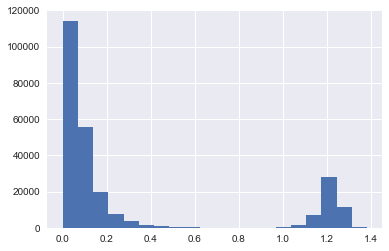

In [20]:
_ = plt.hist(np.log(rank_diffs_slider.rankdiff+1.), bins=20)

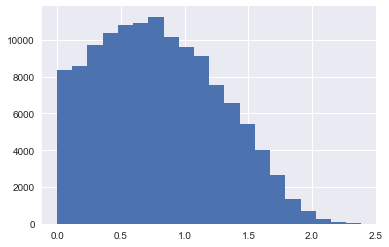

In [21]:
_ = plt.hist(np.log(rank_diffs_duration.rankdiff+1.), bins=20)

In [22]:
%%R -i rank_diffs_duration -i rank_diffs_slider

m.dur <- lmer(log1p(rankdiff) ~ 1 + (1|ann1)+(1|ann2)+(1|pred_token)+(1|sent_token)+(1|hit_id), 
              weights=rank_diffs_duration$confidence,
              data=rank_diffs_duration)
m.rel <- lmer(log1p(rankdiff) ~ 1 + (1|ann1)+(1|ann2)+(1|pred1_token)+(1|pred2_token)+(1|sent_token)+(1|hit_id),
              weights=rank_diffs_slider$confidence,
              data=rank_diffs_slider)


random.effects.dur <- ranef(m.dur)$ann1 + ranef(m.dur)$ann2
random.effects.rel <- ranef(m.rel)$ann1 + ranef(m.rel)$ann2

summary(m.dur)

Linear mixed model fit by REML ['lmerMod']
Formula: log1p(rankdiff) ~ 1 + (1 | ann1) + (1 | ann2) + (1 | pred_token) +  
    (1 | sent_token) + (1 | hit_id)
   Data: rank_diffs_duration
Weights: rank_diffs_duration$confidence

REML criterion at convergence: 131919.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0992 -0.6399  0.0628  0.6998  3.3380 

Random effects:
 Groups     Name        Variance Std.Dev.
 sent_token (Intercept) 0.063907 0.25280 
 pred_token (Intercept) 0.054023 0.23243 
 hit_id     (Intercept) 0.007025 0.08381 
 ann2       (Intercept) 0.005968 0.07725 
 ann1       (Intercept) 0.005968 0.07725 
 Residual               0.064890 0.25474 
Number of obs: 127456, groups:  
sent_token, 5494; pred_token, 3040; hit_id, 2046; ann2, 719; ann1, 719

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.786136   0.008025   97.96


In [28]:
expit(0.786136)

0.68700105328921091

In [23]:
%%R

summary(m.rel)

Linear mixed model fit by REML ['lmerMod']
Formula: log1p(rankdiff) ~ 1 + (1 | ann1) + (1 | ann2) + (1 | pred1_token) +  
    (1 | pred2_token) + (1 | sent_token) + (1 | hit_id)
   Data: rank_diffs_slider
Weights: rank_diffs_slider$confidence

REML criterion at convergence: 305138.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.88767 -0.69801 -0.20176  0.04359  3.14596 

Random effects:
 Groups      Name        Variance  Std.Dev.
 sent_token  (Intercept) 0.0219187 0.14805 
 pred2_token (Intercept) 0.0009993 0.03161 
 pred1_token (Intercept) 0.0019334 0.04397 
 hit_id      (Intercept) 0.0025290 0.05029 
 ann2        (Intercept) 0.0043328 0.06582 
 ann1        (Intercept) 0.0043328 0.06582 
 Residual                0.0862486 0.29368 
Number of obs: 254912, groups:  
sent_token, 5494; pred2_token, 2692; pred1_token, 2066; hit_id, 2046; ann2, 719; ann1, 719

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.311220   0.005243   59.36


In [29]:
expit(0.311220)

0.57718302132627952

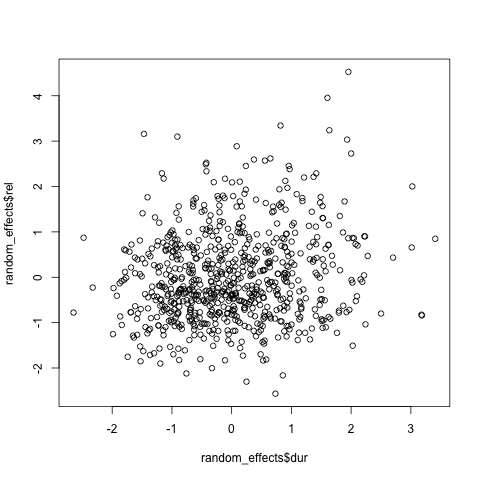

In [30]:
%%R -o random_effects

random.effects.dur$ann <- row.names(random.effects.dur)
random.effects.rel$ann <- row.names(random.effects.rel)

random_effects <- merge(random.effects.dur, random.effects.rel, by='ann')

names(random_effects) <- c('ann', 'dur', 'rel')

random_effects$dur <- (random_effects$dur-mean(random_effects$dur))/sd(random_effects$dur)
random_effects$rel <- (random_effects$rel-mean(random_effects$rel))/sd(random_effects$rel)

plot(random_effects$dur, random_effects$rel)

In [31]:
print(random_effects.shape)
random_effects.head()

(719, 3)


,ann,dur,rel
1,0,0.008069,-0.373834
2,1,-0.583619,0.654842
3,10,-1.986980,-1.252720
4,100,0.817879,3.342635
5,101,-0.111637,0.535749


In [ ]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))